In [1]:
import numpy as np
import tensorflow as tf
import PIL as Image
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, Dense
import os
import math
from matplotlib import pyplot as plt

In [2]:
PATH = 'C:/Users/enes_/Documents/GitHub/Datasets/105_classes_pins_dataset'
train_path = PATH + "/train"
test_path = PATH + "/test"
valid_path = PATH + "/valid"

In [3]:
size = (128, 128)

In [4]:
batch_size = 64

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [6]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = datagen.flow_from_directory(train_path,
                                              batch_size = batch_size,
                                              class_mode = 'categorical', 
                                              target_size = size,
                                              color_mode="rgb",
                                              shuffle=True,
                                              seed=100)

Found 12271 images belonging to 105 classes.


In [8]:
validation_generator = valid_datagen.flow_from_directory(valid_path,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical', 
                                                         target_size = size,
                                                         shuffle=True,
                                                         color_mode="rgb",
                                                         seed=100)

Found 2630 images belonging to 105 classes.


In [9]:
test_generator = valid_datagen.flow_from_directory(test_path,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical', 
                                                         target_size = size,
                                                         shuffle=True,
                                                         seed=100)

Found 2633 images belonging to 105 classes.


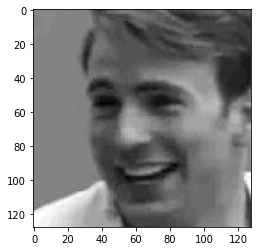

In [10]:
plt.imshow(validation_generator.next()[0][19])

In [11]:
input_shape = train_generator.next()[0].shape[1:]

In [12]:
num_classes = train_generator.next()[1].shape[1]

In [13]:
input_shape

(128, 128, 3)

In [14]:
num_classes

105

In [15]:
num_of_train_samples = 12271
num_of_validation_samples = 2630

optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [16]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=input_shape,
    pooling="max",
    classes=num_classes,
)

model = tf.keras.Sequential()
model.add(Conv2D(64, (64,64),padding='same',activation='relu',input_shape=input_shape,name='conv2d_1'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))
model.add(Conv2D(32, (16,16),activation='relu',name='conv2d_2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(1024,activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(Dense(512,activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(Dense(256,activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(num_classes,activation="softmax"))

In [17]:
class ArcFaceLayer(tf.keras.layers.Layer):
    """
    Implements the ArcFace from equation (3) of `ArcFace: Additive Angular Margin Loss for Deep Face Recognition <https://arxiv.org/abs/1801.07698>`_

    Defined as:

    :math:`s(cos(\\theta_i) + m`

    Parameters
    ----------

      n_classes: int
        Number of classes

      m: float
         Margin

      s: int
         Scale

      arc: bool
         If `True`, uses arcface loss. If `False`, it's a regular dense layer
    """

    def __init__(self, n_classes=10, s=30, m=0.5, arc=True):
        super(ArcFaceLayer, self).__init__(name="arc_face_logits")
        self.n_classes = n_classes
        self.s = s
        self.arc = arc
        self.m = m

    def build(self, input_shape):
        super(ArcFaceLayer, self).build(input_shape[0])
        shape = [input_shape[-1], self.n_classes]

        self.W = self.add_variable("W", shape=shape)

        self.cos_m = tf.identity(math.cos(self.m), name="cos_m")
        self.sin_m = tf.identity(math.sin(self.m), name="sin_m")
        self.th = tf.identity(math.cos(math.pi - self.m), name="th")
        self.mm = tf.identity(math.sin(math.pi - self.m) * self.m)


    def call(self, X, y, training=None):
        if self.arc:
            # normalize feature
            X = tf.nn.l2_normalize(X, axis=1)
            W = tf.nn.l2_normalize(self.W, axis=0)

            # cos between X and W
            cos_yi = tf.matmul(X, W)

            # sin_yi = tf.math.sqrt(1-cos_yi**2)
            sin_yi = tf.clip_by_value(tf.math.sqrt(1 - cos_yi ** 2), 0, 1)

            # cos(x+m) = cos(x)*cos(m) - sin(x)*sin(m)
            cos_yi_m = cos_yi * self.cos_m - sin_yi * self.sin_m

            cos_yi_m = tf.where(cos_yi > self.th, cos_yi_m, cos_yi - self.mm)

            # Preparing the hot-output
            one_hot = tf.one_hot(
                tf.cast(y, tf.int32), depth=self.n_classes, name="one_hot_mask"
            )

            logits = (one_hot * cos_yi_m) + ((1.0 - one_hot) * cos_yi)
            logits = self.s * logits
        else:
            logits = tf.matmul(X, self.W)

        return logits

In [18]:
optimizer = tf.keras.optimizers.Adam()

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [24]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [27]:
new_model = model

In [30]:
new_model = tf.keras.Sequential()

In [31]:
new_model.add(model)

In [32]:
new_model.add(ArcFaceLayer(n_classes=105))

C:\Users\enes_\AppData\Local\Temp\ipykernel_18644\1374763301.py:36: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.W = self.add_variable("W", shape=shape)


TypeError: in user code:


    TypeError: tf__call() missing 1 required positional argument: 'y'


In [ ]:
model.fit(
        train_generator,
        steps_per_epoch=num_of_train_samples/batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=num_of_validation_samples/batch_size)

Epoch 1/20
191/191 [==============================] - 72s 375ms/step - loss: 2.0916 - accuracy: 0.4384 - val_loss: 3.5587 - val_accuracy: 0.2152
Epoch 2/20
191/191 [==============================] - 72s 375ms/step - loss: 1.9333 - accuracy: 0.4756 - val_loss: 3.1267 - val_accuracy: 0.3114
Epoch 3/20
191/191 [==============================] - 68s 356ms/step - loss: 1.7611 - accuracy: 0.5108 - val_loss: 2.8745 - val_accuracy: 0.2711
Epoch 4/20
191/191 [==============================] - 70s 362ms/step - loss: 1.7254 - accuracy: 0.5183 - val_loss: 4.6100 - val_accuracy: 0.1388
Epoch 5/20
191/191 [==============================] - 69s 361ms/step - loss: 1.5929 - accuracy: 0.5599 - val_loss: 4.1257 - val_accuracy: 0.2361
Epoch 6/20
191/191 [==============================] - 71s 368ms/step - loss: 1.4696 - accuracy: 0.5850 - val_loss: 3.1277 - val_accuracy: 0.3361
Epoch 7/20
191/191 [==============================] - 71s 367ms/step - loss: 1.3708 - accuracy: 0.6123 - val_loss: 3.1450 - val_ac

model.save(r"C:\Users\enes_\Documents\GitHub\Meturone\Meturone\Celebrity CNN")

model_linear = tf.keras.Sequential()
model_linear.add(Flatten())
model_linear.add(Dense(4096,activation='relu'))
model_linear.add(Dense(2048,activation='relu'))
model_linear.add(Dense(1024,activation='relu'))
model_linear.add(Dense(512,activation='relu'))
model_linear.add(Dense(num_classes,activation="softmax"))

model_linear.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

model_linear.fit(
        train_generator,
        steps_per_epoch=num_of_train_samples/batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=num_of_validation_samples/batch_size)

model_trained = tf.keras.models.load_model(r"C:\Users\enes_\Documents\GitHub\Meturone\Meturone\Celebrity CNN")

model_trained.summary()

model_trained.evaluate(test_generator)

print(model_trained.history.history.values())

print(model.history.history.keys())

model_trained.history.history["accuracy"][-1]